In [1]:
'''Will fill up the steps later
Manual scrubbing the excel file:
1. Had to change the humidity information from the building data to the data from Nashville Weather since it is not working
2. Had to remove the ??? values at the time stamps mentioned below
3. Had to remove sustained rows with 0 values in CC_T column from AHU_CHW excel file.'''

'Will fill up the steps later\nManual scrubbing the excel file:\n1. Had to change the humidity information from the building data to the data from Nashville Weather since it is not working\n2. Had to remove the ??? values at the time stamps mentioned below\n3. Had to remove sustained rows with 0 values in CC_T column from AHU_CHW excel file.'

In [1]:
#import modules
from pandas import *
from matplotlib import *
import numpy as np
from CoolProp.CoolProp import PropsSI,Props
from CoolProp.HumidAirProp import HAPropsSI
# import seaborn
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline
options.display.max_columns = 100
# import re

In [2]:
#Reading the different Excel Sheets containing different Data Columns
df1 = read_excel('RelevantCollatedData.xlsx',sheet_name="Sheet1")
#sample type 1 date='11/4/18 1:00:00 AM CDT'
#sample type 2 date='11/4/18 2:00:00 AM CST'
df1.Time = df1.Time.map(lambda x: x.rsplit(None, 1)[0])#removing time zone information #no axis info since it is a series
df1.insert(loc=0, column='Dates', value=to_datetime(df1['Time'],format='%m/%d/%y %I:%M:%S %p'))
df1.set_index(['Dates'], drop=True, inplace=True)
df1.drop('Time',axis=1,inplace=True)#Drop original Time column
df1.index.is_unique #Statutory Check

True

In [3]:
df2 = read_excel('RelevantCollatedData.xlsx',sheet_name="Sheet2")
df2.insert(loc=0, column='Dates', value=to_datetime(df2['Date'],format='%m/%d/%Y %H:%M'))
df2.set_index(['Dates'], drop=True, inplace=True)
df2.drop('Date',axis=1,inplace=True)
df2.index.is_unique #Statutory Check

True

In [4]:
df3 = read_excel('RelevantCollatedData.xlsx',sheet_name="Sheet3")
df3.insert(loc=0, column='Dates', value=to_datetime(df3['Date'],format='%m/%d/%Y %H:%M'))
df3.set_index(['Dates'], drop=True, inplace=True)
df3.drop('Date',axis=1,inplace=True)
df3.index.is_unique #Statutory Check

True

In [5]:
df4 = read_excel('RelevantCollatedData.xlsx',sheet_name="Sheet4")
df4.insert(loc=0, column='Dates', value=to_datetime(df4['Date'],format='%m/%d/%Y %H:%M'))
df4.set_index(['Dates'], drop=True, inplace=True)
df4.drop('Date',axis=1,inplace=True)
df4.index.is_unique #Statutory Check

True

In [6]:
#Now we shall merge the individual dataframes
totalData = concat([df1,df2,df3,df4],axis=1,sort=True)#totalData.shape = (64828, 16)

In [19]:
totalData.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')

In [13]:
totalData.drop(['OutdoorAirEnthalpy'], axis=1,inplace=True)

In [15]:
totalData.dropna(axis=0,how='any',inplace=True)#Now we drop rows with NaN values

In [2]:
#totalData.to_pickle("./totalData.pkl")
totalData = read_pickle("./totalData.pkl")
#Notneeded!!totalData.columns = list(range(totalData.shape[1]))
#r = list(map(lambda x: Timestamp(x), ['2018-08-29 13:05:00','2018-08-29 13:10:00','2018-08-29 13:15:00','2018-08-29 13:20:00']))
#totalData.drop(index =r,inplace=True)
#totalData.to_csv("./totalData.csv")

In [4]:
t = totalData.iloc[0,[0,1]].to_numpy()
t.shape

(2,)

In [ ]:
'''END OF DATA COLLECTION AND MERGING'''

In [52]:
'''Index(['Outside Air Temperature.Outside Air Temperature.Trend - Present Value ()',
       'Discharge Air Temperature.Discharge Air Temperature.Trend - Present Value ()',
       'Discharge Air Flow.Discharge Air Flow.Trend - Present Value ()',
       'Chilled Water Valve Ouptut.Chilled Water Valve Ouptut.Trend - Present Value ()',
       'Reheat Output.Reheat Output.Trend - Present Value ()',
       'Preheat Output.Preheat Output.Trend - Present Value ()',
       'PHT_SPT.value',
       'CCT_SPT.value', 
       'PH_T.value',
       'PHFBD_O.value',
       'CC_T.value',
       'AHU_1.supplyAirTempSetpoint',
       'AHU_1.outdoorAirHumidity',
       'DewPoint',
       'Pressure'],
      dtype='object')
'''
Units = ['F','F','cfm','%','%','%','F','F','F','%','F','F','%','F','inches']

In [2]:
import math

def Part_press(P,W):
    
    ''' Function to compute partial vapor pressure in [kPa]
        From page 6.9 equation 38 in ASHRAE Fundamentals handbook (2005)
            P = ambient pressure [kPa]
            W = humidity ratio [kg/kg dry air]
    '''
    result = P * W / (0.62198 + W)
    return result


def Sat_press(Tdb):

    ''' Function to compute saturation vapor pressure in [kPa]
        ASHRAE Fundamentals handbood (2005) p 6.2, equation 5 and 6
            Tdb = Dry bulb temperature [degC]
            Valid from -100C to 200 C
    '''

    C1 = -5674.5359
    C2 = 6.3925247
    C3 = -0.009677843
    C4 = 0.00000062215701
    C5 = 2.0747825E-09
    C6 = -9.484024E-13
    C7 = 4.1635019
    C8 = -5800.2206
    C9 = 1.3914993
    C10 = -0.048640239
    C11 = 0.000041764768
    C12 = -0.000000014452093
    C13 = 6.5459673
 
    TK = Tdb + 273.15                     # Converts from degC to degK
    
    if TK <= 273.15:
        result = math.exp(C1/TK + C2 + C3*TK + C4*TK**2 + C5*TK**3 + 
                          C6*TK**4 + C7*math.log(TK)) / 1000
    else:
        result = math.exp(C8/TK + C9 + C10*TK + C11*TK**2 + C12*TK**3 + 
                          C13*math.log(TK)) / 1000
    return result

def Hum_rat2(Tdb, RH, P=101.325):

    ''' Function to calculate humidity ratio [kg H2O/kg air]
        Given dry bulb and wet bulb temperature inputs [degC]
        ASHRAE Fundamentals handbood (2005)
            Tdb = Dry bulb temperature [degC]
            RH = Relative Humidity [Fraction or %]
            P = Ambient Pressure [kPa]
    '''
    Pws = Sat_press(Tdb)
    result = 0.62198*RH*Pws/(P - RH*Pws)    # Equation 22, 24, p6.8
    return result

def Rel_hum2(Tdb, W, P=101.325):
    
    ''' Calculates the relative humidity given:
            Tdb = Dry bulb temperature [degC]
            P = ambient pressure [kPa]
            W = humidity ratio [kg/kg dry air]
    '''

    Pw = Part_press(P, W)
    Pws = Sat_press(Tdb)
    result = Pw / Pws
    return result

#Functions which are preferred for calculating different factors
#H/h
def Enthalpy_Air_H2O(Tdb, W):#Enthalpy of dry air
    
    ''' Calculates enthalpy in kJ/kg (dry air) given:
            Tdb = Dry bulb temperature [K]
            W = Humidity Ratio [kg/kg dry air]
        Calculations from 2005 ASHRAE Handbook - Fundamentals - SI P6.9 eqn 32
    '''
    Tdb  = Tdb - 273.15
    result = 1.006*Tdb + W*(2501 + 1.86*Tdb)
    return result

#h_w
def specificEnthalpyWater(T):#returns kJ/Kg of condensed water at T K 
    return PropsSI('H', 'T', T, 'Q', 0, 'Water')/1000 # gives specific centhalpy of water which condensed at TK

#W
def HumidityRatio(Tdb,R,P=101325):# returns Kg-of-moisture/Kg-DryAir at sea level eg HumidityRatio(293.15,0.6)
    return HAPropsSI('W','T',Tdb,'R',R ,'P',P);#Kg moisture/Kg Dry Air

#R
def RelativeHumidty(W,Tdb,P=101325):#returns relative humidity of air for W:kg/kg humidity ratio and T in Kelvin
    return HAPropsSI('R','W',W,'T',Tdb,'P',P)#unitless

#v_1/v
def specificVolume(Tdb,W,P=101.325):#Tdb:K; W=kg/kg; P=kPa
    return 0.2871*(Tdb)*(1 + 1.6078*W)/P#m3/Kg

In [21]:
#Calculating pre heating energy
c_pm = 1.0216 #kJ/kg of dry air
#function call should be totalData['PH_T_energy'] = totalData.apply(lambda x: PreHeatEnergy(x) , axis=1)
def PreHeatEnergy(rowInfo): #rowInfo should pass a dataframe for easy access via column headers hence pass df.iloc[[i]]
                     #Value       #Unit
    facepercentage = rowInfo[9]/100#%
    airflow = rowInfo[2]*0.0004719474#m3/s
    P = rowInfo[14]*3386.389 #Pa
    Tdb_in = 273.15+(rowInfo[0] - 32)*5/9 #K
    RH = rowInfo[12]/100#fraction
    Tdb_out = 273.15 + (rowInfo[8] - 32)*5/9 #K
    W = HumidityRatio(Tdb_in,RH,P)# returns Kg-of-moisture/Kg-DryAir
    v_1 = specificVolume(Tdb_in,W,P/100)#m3/Kg
    Hin = Enthalpy_Air_H2O(Tdb_in, W)
    Hout= Enthalpy_Air_H2O(Tdb_out, W)
    m_a = airflow/v_1
    return facepercentage*m_a*(Hout-Hin)
totalData['PH_T_energy'] = totalData.apply(lambda x: PreHeatEnergy(x) , axis=1)
# totalData.plot(y='PH_T_energy',figsize=(40,20),style='k*-')

In [32]:
#Calculating the cooling energy
def CoolingEnergy(rowInfo):
    ccoutput = rowInfo[3] # %
    if ccoutput>0:#encodes the humidity changeover setpoint information?
        
        P = rowInfo[14]*3386.389 #Pa
        airflow = rowInfo[2]*0.0004719474#m3/s
        
        dewPT_at_CC = 273.15+(rowInfo[13] - 32)*5/9 #K
        #Since preheat coil does sensible heating, dewPT is the same
        ccSPT = 273.15+(rowInfo[7] - 32)*5/9 #K
        
        if dewPT_at_CC>=ccSPT:# ie always ends at saturation line with 100% RH and CCT_T
            
            Tdb_in_pht = 273.15+(rowInfo[0] - 32)*5/9 #K
            RH_in = rowInfo[12]/100#fraction
            W_in_cc = HumidityRatio(Tdb_in_pht,RH_in,P)# returns Kg-of-moisture/Kg-DryAir
            #Since pht is sensible heating, W_in_pht=W_in_cc remains same
            Tdb_in_cc= 273.15 + (rowInfo[8] - 32)*5/9 #K
            v_1 = specificVolume(Tdb_in_cc,W_in_cc,P/100)#m3/Kg
            m_a = airflow/v_1
            
            Tdb_out_cc= 273.15 + (rowInfo[10] - 32)*5/9 #K
            H_w = specificEnthalpyWater(Tdb_out_cc)
            W_out_cc = HumidityRatio(Tdb_out_cc,1.0,P)# returns Kg-of-moisture/Kg-DryAir RH_out=1.0
            
            
            H_in = Enthalpy_Air_H2O(Tdb_in_cc, W_in_cc)
            H_out = Enthalpy_Air_H2O(Tdb_out_cc, W_out_cc)
            
            Energy = m_a*(H_in-H_out)-m_a*(W_in_cc-W_out_cc)*H_w
            return Energy
            
        else:# dewPT_at_CC<ccSPT ie only sensible cooling is done,
            Tdb_in_pht = 273.15+(rowInfo[0] - 32)*5/9 #K
            RH_in = rowInfo[12]/100#fraction
            W_in_cc = HumidityRatio(Tdb_in_pht,RH_in,P)# returns Kg-of-moisture/Kg-DryAir
            #Since pht is sensible heating, W_in_pht=W_in_cc remains same
            Tdb_in_cc= 273.15 + (rowInfo[8] - 32)*5/9 #K
            v_1 = specificVolume(Tdb_in_cc,W_in_cc,P/100)#m3/Kg
            m_a = airflow/v_1
            
            Tdb_out_cc= 273.15 + (rowInfo[10] - 32)*5/9 #K
            W_out_cc = W_in_cc
            
            H_in = Enthalpy_Air_H2O(Tdb_in_cc, W_in_cc)
            H_out = Enthalpy_Air_H2O(Tdb_out_cc, W_out_cc)

            Energy = m_a*(H_in-H_out)
            return Energy
        
    else:
        return 0
#totalData['Cooling_energy'] = totalData.apply(lambda x: CoolingEnergy(x) , axis=1)

In [58]:
#Calculating the reheating energy
def ReheatEnergy(rowInfo):
    #Either air is at 100% RH and CCT_T or it is at W_in_cc humidity ratio with CCT_T
    rhoutput = rowInfo[4] # %
    if rhoutput>0:
        P = rowInfo[14]*3386.389 #Pa
        airflow = rowInfo[2]*0.0004719474#m3/s
        
        dewPT_at_CC = 273.15+(rowInfo[13] - 32)*5/9 #K
        #Since preheat coil does sensible heating, dewPT is the same
        ccSPT = 273.15+(rowInfo[7] - 32)*5/9 #K
        
        if dewPT_at_CC>=ccSPT:# ie always starts at saturation line with 100% RH and CCT_T
        
            Tdb_in_rht = 273.15 + (rowInfo[10] - 32)*5/9 #K
            RH_in = 1.0 #fraction
            W_in_rht = HumidityRatio(Tdb_in_rht,RH_in,P)# returns Kg-of-moisture/Kg-DryAir
            v_1 = specificVolume(Tdb_in_rht,W_in_rht,P/100)#m3/Kg
            m_a = airflow/v_1
            
            H_in = Enthalpy_Air_H2O(Tdb_in_rht, W_in_rht)
            Tdb_out_rht= 273.15 + (rowInfo[1] - 32)*5/9 #K
            W_out_rht=W_in_rht #Sensible heating
            H_out = Enthalpy_Air_H2O(Tdb_out_rht,W_out_rht)
            
            Energy = m_a*(H_out-H_in)
            return Energy
            
        else:#at W_in_cc humidity ratio with CCT_T
            Tdb_in_pht = 273.15+(rowInfo[0] - 32)*5/9 #K
            RH_in = rowInfo[12]/100#fraction
            W_in_cc = HumidityRatio(Tdb_in_pht,RH_in,P)# returns Kg-of-moisture/Kg-DryAir
            #Since pht,cct,rht is sensible heating, W_in_rht=W_in_cc remains same
            Tdb_in_rht = 273.15 + (rowInfo[10] - 32)*5/9 #K
            v_1 = specificVolume(Tdb_in_rht,W_in_cc,P/100)#m3/Kg
            m_a = airflow/v_1
            
            W_in_rht=W_in_cc
            W_out_rht=W_in_cc #Sensible heating
            
            H_in = Enthalpy_Air_H2O(Tdb_in_rht, W_in_rht)
            Tdb_out_rht= 273.15 + (rowInfo[1] - 32)*5/9 #K
            H_out = Enthalpy_Air_H2O(Tdb_out_rht,W_out_rht)
            
            Energy = m_a*(H_out-H_in)
            return Energy
        
    else:
        return 0
#totalData['Reheat_energy'] = totalData.apply(lambda x: ReheatEnergy(x) , axis=1)

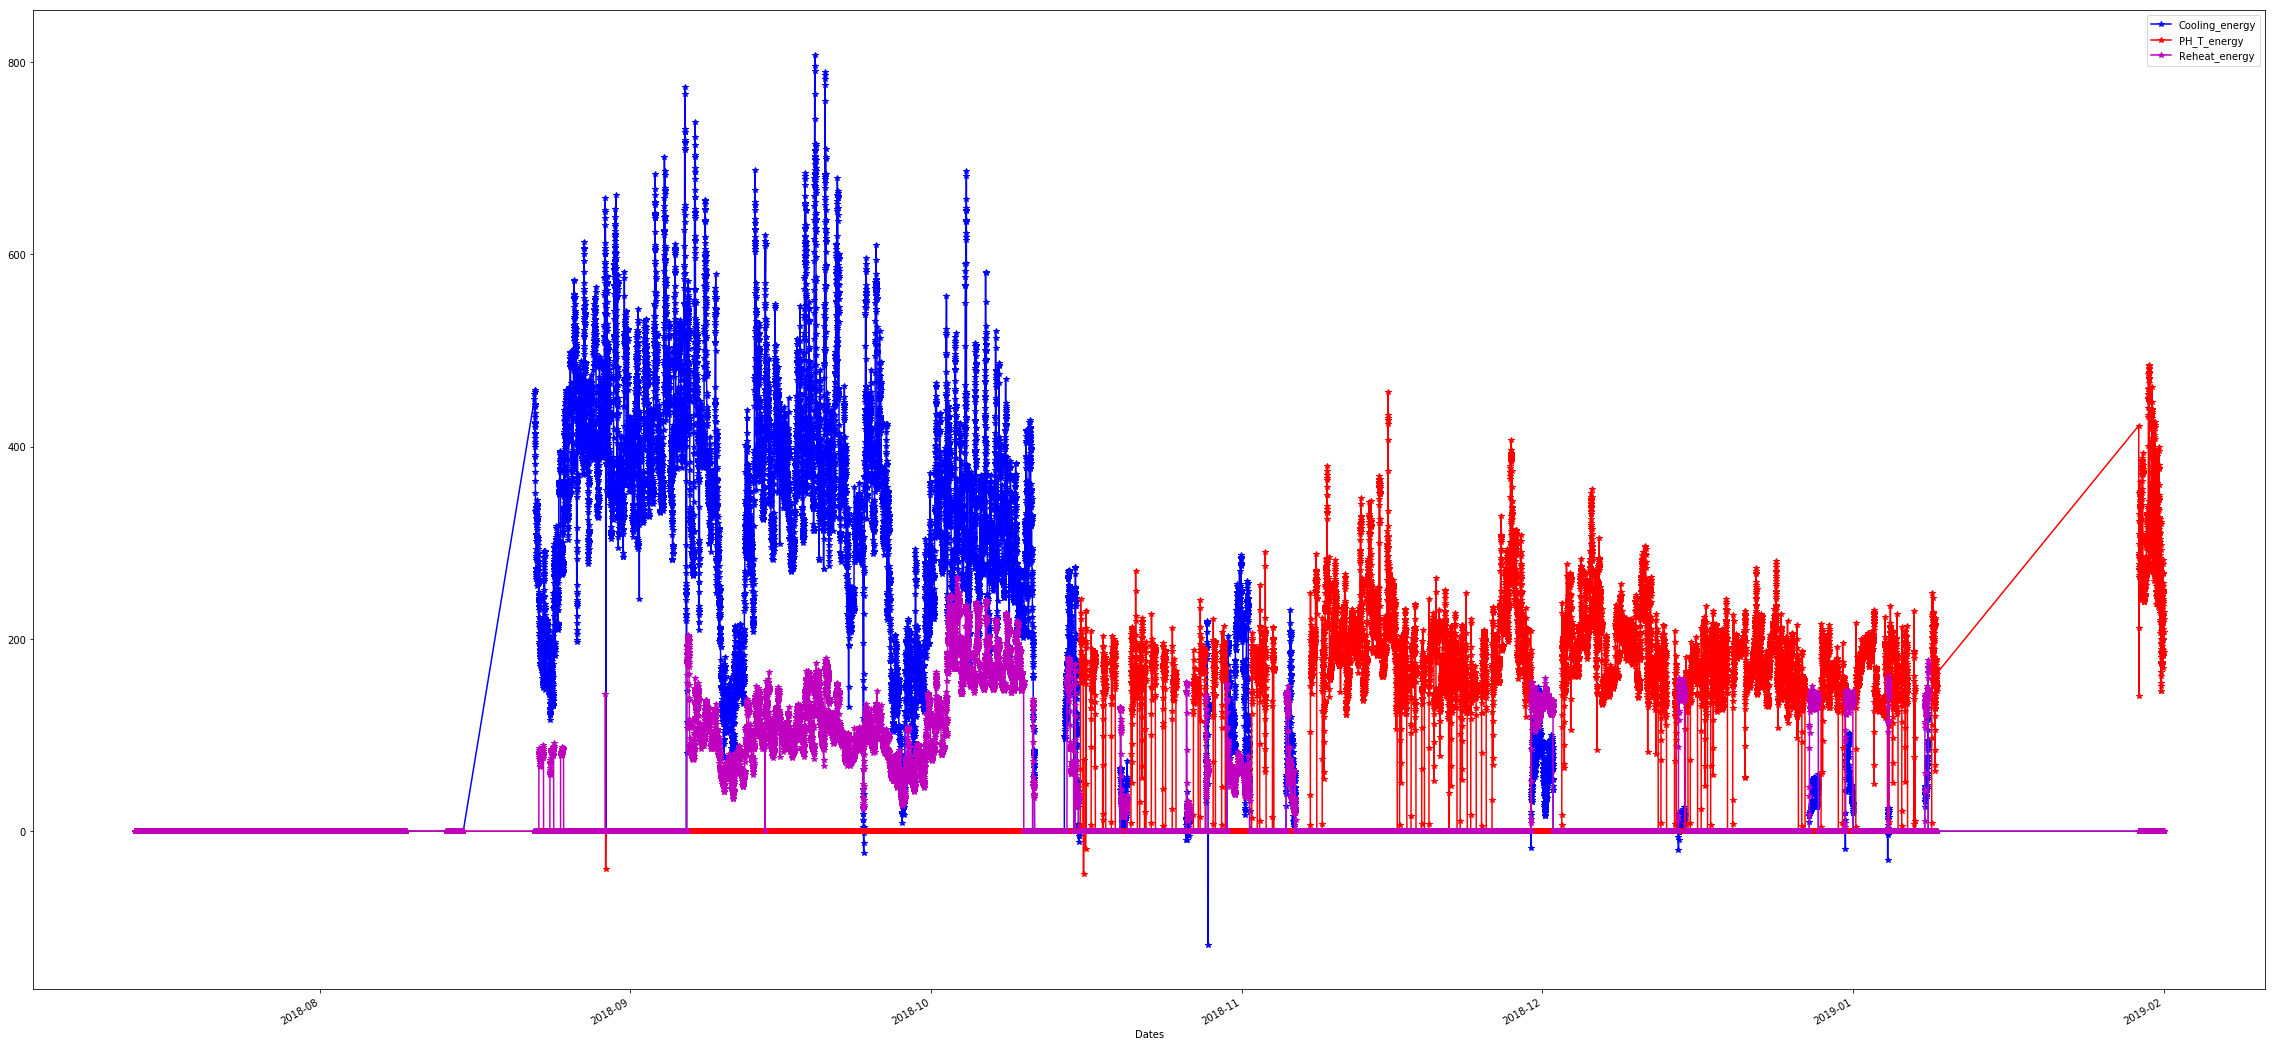

In [64]:
totalData.plot(y=['Cooling_energy','PH_T_energy','Reheat_energy'],figsize=(40,20),style=['b*-','r*-','m*-'])

In [ ]:
'''Index(['Outside Air Temperature.Outside Air Temperature.Trend - Present Value ()',
       'Discharge Air Temperature.Discharge Air Temperature.Trend - Present Value ()',
       'Discharge Air Flow.Discharge Air Flow.Trend - Present Value ()',
       'Chilled Water Valve Ouptut.Chilled Water Valve Ouptut.Trend - Present Value ()',
       'Reheat Output.Reheat Output.Trend - Present Value ()',
       'Preheat Output.Preheat Output.Trend - Present Value ()',
       'PHT_SPT.value',
       'CCT_SPT.value', 
       'PH_T.value',
       'PHFBD_O.value',
       'CC_T.value',
       'AHU_1.supplyAirTempSetpoint',
       'AHU_1.outdoorAirHumidity',
       'DewPoint',
       'Pressure'],
      dtype='object')
'''
#Units = ['F','F','cfm','%','%','%','F','F','F','%','F','F','%','F','inches']

In [12]:
#dfAnalysis = totalData.loc[Timestamp('2018-08-22 10:30:00'):]
dfAnalysis = totalData.loc[Timestamp('2018-09-01 00:00:00'):Timestamp('2018-09-30 23:55:00')]

In [ ]:
#To understand the importance of RHT_OP
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

X_input = dfAnalysis[[1,2,10,11,12]].to_numpy()
Y_output = dfAnalysis[[4]].to_numpy()
X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.30, shuffle=True)

learner = GBR(n_estimators=500)
learner.fit(X_train,y_train)
learner.score(X_train,y_train)  #0.9528335338347232
#learner.feature_importances_   array([0.45171715, 0.00777939, 0.40505949, 0.09618992, 0.03925405])
#learner.score(X_test,y_test)  #0.9483157707848978
'''Hence we see that reheat output depends primarily on the DAT and the Cooling Coil Teperature ie temp of aircoming from the cooling coils'''

In [ ]:
'''Next step:
Select data for a month:09 to 10---cooling regime
Select DichTemp, CC_STPT as the control variables and evaluate energy for the summer regime
'''
totalData.head()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f681a5198>]],
      dtype=object)

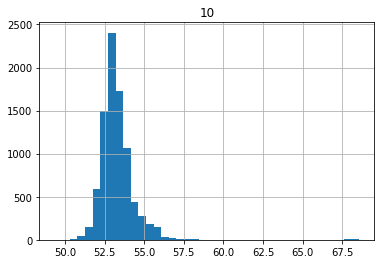

In [9]:
dfAnalysis.hist(column=10,bins=40)


In [17]:
DFStats = dfAnalysis.describe()# this is also a dataframe
CCT_mean_at53 = DFStats.loc['mean',10]
CCT_std_at53 = DFStats.loc['std',10]

In [26]:
CCT_std_at53

1.2146825940667194

In [23]:
np.random.normal(0,1.2146825940667194,1)[0]

0.26720089572500616

In [19]:
dfAnalysis.hist(column=1,bins=40)

NameError: name 'dfAnalysis' is not defined

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c3b49dfd0>]],
      dtype=object)

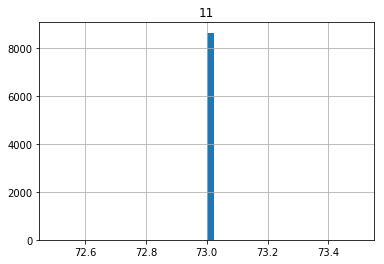

In [13]:
dfAnalysis.hist(column=11,bins=40)

In [2]:
#Adding data from the AHU2
#Reading the different Excel Sheets containing different Data Columns
df5 = read_excel('AHU2_newData.xlsx',sheet_name="Sheet2")
#sample type 1 date='11/4/18 1:00:00 AM CDT'
#sample type 2 date='11/4/18 2:00:00 AM CST'
df5.Time = df5.Time.map(lambda x: x.rsplit(None, 1)[0])#removing time zone information #no axis info since it is a series
df5.insert(loc=0, column='Dates', value=to_datetime(df5['Time'],format='%m/%d/%y %I:%M:%S %p'))
df5.set_index(['Dates'], drop=True, inplace=True)
df5.drop('Time',axis=1,inplace=True)#Drop original Time column
df5.index.is_unique #Statutory Check

True

In [3]:
df6 = read_excel('AHU2_newData.xlsx',sheet_name="Sheet1")
df6.insert(loc=0, column='Dates', value=to_datetime(df6['Date'],format='%m/%d/%Y %H:%M'))
df6.set_index(['Dates'], drop=True, inplace=True)
df6.drop('Date',axis=1,inplace=True)
df6.index.is_unique #Statutory Check

True

In [4]:
#Now we shall merge the individual dataframes
totalData2 = concat([df5,df6],axis=1,sort=True)
totalData2.dropna(axis=0,how='any',inplace=True)#Now we drop rows with NaN values

In [5]:
totalData2.dtypes

PHO_AHU2           float64
PHT_SPT_2.value    float64
CC_T_2.value       float64
CCT_SPT_2.value    float64
PH_T_2.value       float64
PHFBD_O_2.value    float64
dtype: object

In [14]:
totalData2.to_pickle("./AHU2_Data.pkl")

In [15]:
'''Trying to calculate the CF for the cooling coil'''

'Trying to calculate the CF for the cooling coil'

In [55]:
'''Attempting to calculate the Contact Factor. Only works when preheat and reheat output are both 0'''
coolOnly = totalData[totalData[4] == 0]#removing reheat output
coolOnly = coolOnly[coolOnly[5] == 0]#removing preheat output
coolOnly = coolOnly[coolOnly[2] > 0]#removing negative flow values
coolOnly = coolOnly[coolOnly[3] > 0]#removing 0 cooloutput values
coolOnly[0] = coolOnly[0].astype(np.float)

#Trying an alternative to calculate the CF better
coolOnly = coolOnly[coolOnly[12] < 50]#removing 0 cooloutput values

In [35]:
coolOnly.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,PH_T_energy,Cooling_energy
Dates,,,,,,,,,,,,,,,,,
2018-08-22 10:30:00,80.43682,65.19009,2527.190,60.18574,0.0,0.0,73.0,53.0,77.985558,0.0,52.949505,65.0,71.0,64.9,30.11,-0.0,449.777305
2018-08-22 10:35:00,80.45648,65.19009,2530.330,60.18574,0.0,0.0,73.0,53.0,78.585236,0.0,52.949505,65.0,71.0,64.9,30.11,-0.0,454.958674
2018-08-22 10:40:00,81.16954,65.48759,2526.703,60.18574,0.0,0.0,73.0,53.0,78.254623,0.0,53.253326,65.0,71.0,64.9,30.11,-0.0,459.124868
2018-08-22 10:45:00,81.14250,65.78799,2527.258,61.21768,0.0,0.0,73.0,53.0,77.935196,0.0,53.253326,65.0,71.0,64.9,30.11,-0.0,456.461459
2018-08-22 10:50:00,80.38046,65.49070,2519.982,61.21768,0.0,0.0,73.0,53.0,77.960747,0.0,53.253326,65.0,71.0,64.9,30.11,-0.0,441.561133


In [56]:
coolOnly.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,PH_T_energy,Cooling_energy
count,853.000000,853.000000,853.000000,853.000000,853.0,853.0,853.000000,853.0,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000
mean,87.888144,72.955267,2459.017642,75.901942,0.0,0.0,71.526377,53.0,85.962995,0.117233,54.211078,68.929660,43.657679,64.115592,30.130821,-0.045706,359.605028
std,5.186054,4.390255,272.965595,20.523205,0.0,0.0,1.500648,0.0,5.091577,3.423935,1.659242,4.001728,3.799562,5.104932,0.054403,1.334887,107.731046
min,64.426700,62.189820,2070.433000,2.111901,0.0,0.0,70.000000,53.0,64.392883,0.000000,51.257454,65.000000,34.000000,46.900000,29.870000,-38.986931,-118.109126
25%,84.365320,69.962420,2170.519000,58.682400,0.0,0.0,70.000000,53.0,82.431763,0.000000,52.954994,65.000000,41.000000,64.000000,30.100000,-0.000000,287.855430
50%,89.409970,73.327400,2421.401000,66.991670,0.0,0.0,73.000000,53.0,87.747002,0.000000,53.595364,65.000000,44.000000,66.000000,30.120000,-0.000000,382.016472
75%,91.483300,76.964390,2552.966000,99.299160,0.0,0.0,73.000000,53.0,89.978226,0.000000,55.697441,73.000000,47.000000,66.900000,30.160000,-0.000000,443.042650
max,96.227620,85.959940,3229.358000,100.000000,0.0,0.0,73.000000,53.0,92.986542,100.000000,65.128456,73.000000,49.000000,70.000000,30.260000,-0.000000,606.482238


In [ ]:
def contactFactor(rowInfo):
    PreCoolTemp = rowInfo[0]#outside temperature
    PostCoolTemp = rowInfo[1]#discharge air temperature
    CooliingCoilTemp = rowInfo[10]
    CF = (PreCoolTemp-PostCoolTemp)/(PreCoolTemp-CooliingCoilTemp)
    return CF
coolOnly['instant_CF'] = coolOnly.apply(lambda x: contactFactor(x) , axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1255f97eb8>]],
      dtype=object)

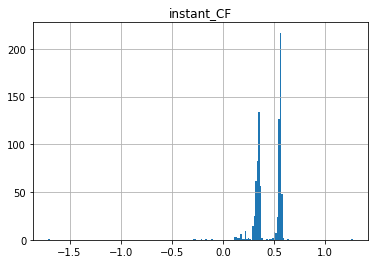

In [58]:
coolOnly.hist(column=['instant_CF'],bins=200)

In [59]:
CF = coolOnly[['instant_CF',2]]
CF = CF[CF['instant_CF']<1]
CF = CF[CF['instant_CF']>0]


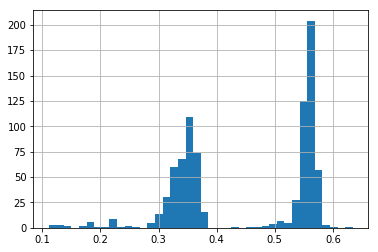

In [61]:
CF['instant_CF'].hist(bins=40)

In [62]:
CF.mean()

instant_CF       0.448355
2             2456.335883
dtype: float64

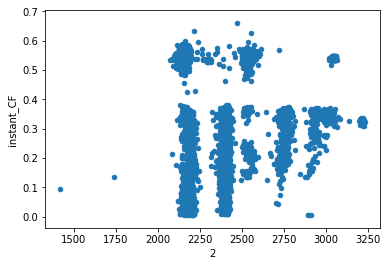

In [87]:
CF.plot(kind='scatter',y='instant_CF',x=2)

In [3]:
totalData = totalData[totalData[2]>0]#removing negative fan flow values
totalData.shape

(40857, 17)

In [12]:
RL_data.shape

(10710, 17)

In [4]:
#Preparing the data for the Preheat=0; RelativeHumidity>60%; OAT>52F; Reheat>0; Cool>0
RL_data = totalData[totalData[5]==0]#PreHeat=0

In [5]:
RL_data = RL_data[RL_data[12]>60]#RelativeHumidity>60%

In [8]:
RL_data = RL_data[RL_data[0]>52]#OAT>52F

In [10]:
RL_data = RL_data[RL_data[4]>0]#Reheat>0

In [11]:
RL_data = RL_data[RL_data[3]>0]#Cool>0

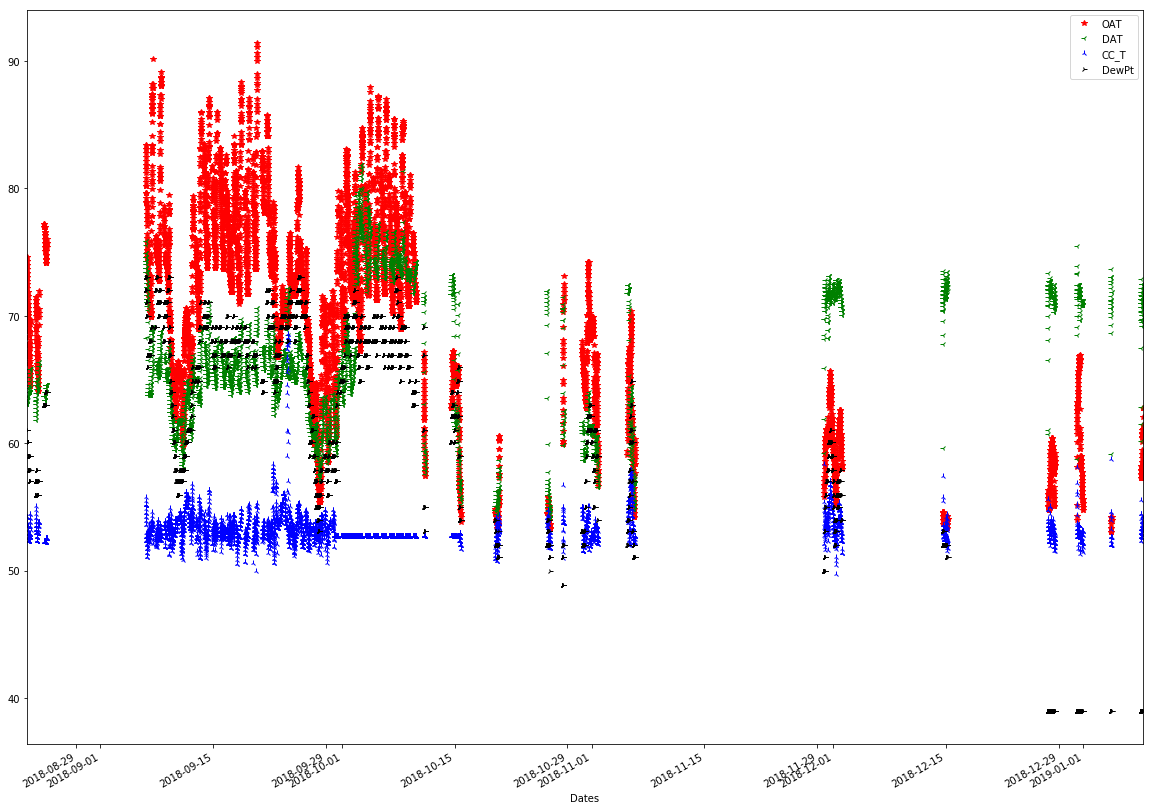

In [18]:
RL_data.plot(y=[0,1,10,13],style=['r*','g3','b2','k4'],figsize=(20,15),label=['OAT','DAT','CC_T','DewPt'])

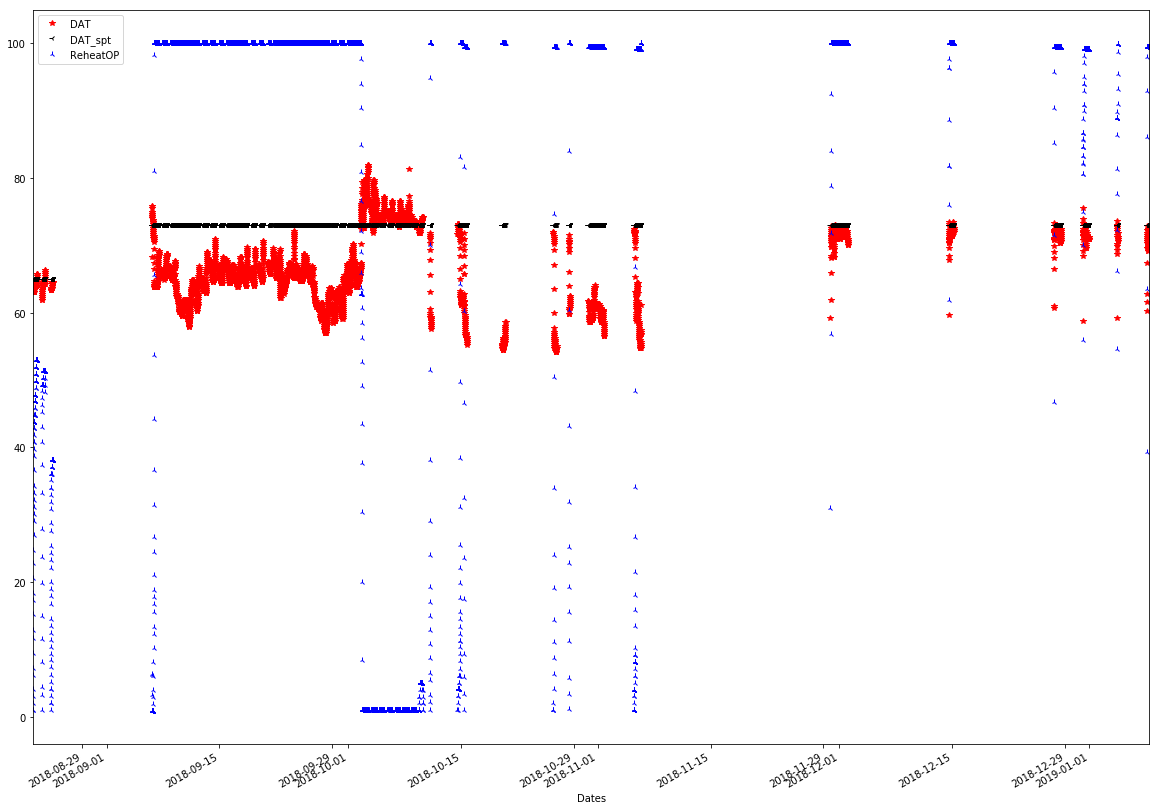

In [23]:
'''As we can see under high humidity, the cooling in blue is so intense than the 
dew point. As a result, the reheat has to heat it up so much that it almost needs 100% heat
'''
RL_data.plot(y=[1,11,4],style=['r*','k3','b2'],figsize=(20,15),label=['DAT','DAT_spt','ReheatOP'])

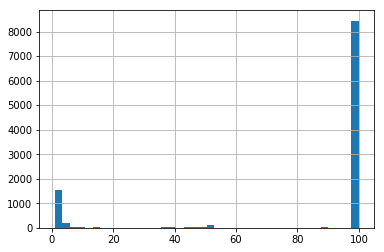

In [17]:
RL_data[4].hist(bins=40)

In [15]:
RL_data[10].mean()

53.373350121971136

In [16]:
RL_data[10].std()

1.2876331552182259

In [14]:
def CooledAirTemp(PHT_TMP,CC_STP):
    StDev = 1.2876331552182259
    CF = 0.55#0.35420179162517795
    
    CC_T = CC_STP + np.random.normal(0,StDev,1)[0]
    ActualCooledTemp = PHT_TMP - CF*(PHT_TMP-CC_T)
    
    return ActualCooledTemp
    

In [6]:
#new Cooling Energy Formulation
#Calculating the cooling energy
def CoolingEnergy(rowInfo,ActualCooledTemp):
    ccoutput = rowInfo[3] # %
    if ccoutput>0:#encodes the humidity changeover setpoint information?
        
        P = rowInfo[14]*3386.389 # to Pa
        airflow = rowInfo[2]*0.0004719474 # to m3/s
        
        dewPT_at_CC = 273.15+(rowInfo[13] - 32)*5/9 #K
        #Since preheat coil does sensible heating, dewPT is the same
        ccSPT = 273.15+(rowInfo[7] - 32)*5/9 #K
        
        if dewPT_at_CC>=ccSPT:# ie always ends at saturation line with 100% RH and CCT_T
            
            Tdb_in_pht = 273.15+(rowInfo[0] - 32)*5/9 #K
            RH_in = rowInfo[12]/100#fraction
            W_in_cc = HumidityRatio(Tdb_in_pht,RH_in,P)# returns Kg-of-moisture/Kg-DryAir
            #Since pht is sensible heating, W_in_pht=W_in_cc remains same
            Tdb_in_cc= 273.15 + (rowInfo[8] - 32)*5/9 #K
            v_1 = specificVolume(Tdb_in_cc,W_in_cc,P/100)#m3/Kg
            m_a = airflow/v_1#Kg/s
            
            Tdb_out_cc = 273.15 + (ActualCooledTemp - 32)*5/9 #K
            CC_T= 273.15 + (rowInfo[10] - 32)*5/9 #K
            H_w = specificEnthalpyWater(CC_T)
            W_out_cc = HumidityRatio(Tdb_out_cc,1.0,P)# returns Kg-of-moisture/Kg-DryAir RH_out=1.0
            
            
            H_in = Enthalpy_Air_H2O(Tdb_in_cc, W_in_cc)
            H_out = Enthalpy_Air_H2O(Tdb_out_cc, W_out_cc)
            
            Energy = m_a*(H_in-H_out)-m_a*(W_in_cc-W_out_cc)*H_w
            return Energy
            
        else:# dewPT_at_CC < ccSPT ie only sensible cooling is done,
            Tdb_in_pht = 273.15+(rowInfo[0] - 32)*5/9 #K
            RH_in = rowInfo[12]/100#fraction
            W_in_cc = HumidityRatio(Tdb_in_pht,RH_in,P)# returns Kg-of-moisture/Kg-DryAir
            #Since pht is sensible heating, W_in_pht=W_in_cc remains same
            Tdb_in_cc= 273.15 + (rowInfo[8] - 32)*5/9 #K
            v_1 = specificVolume(Tdb_in_cc,W_in_cc,P/100)#m3/Kg
            m_a = airflow/v_1
            
            Tdb_out_cc = 273.15 + (ActualCooledTemp - 32)*5/9 #K
            CC_T= 273.15 + (rowInfo[10] - 32)*5/9 #K
            W_out_cc = W_in_cc
            
            H_in = Enthalpy_Air_H2O(Tdb_in_cc, W_in_cc)
            H_out = Enthalpy_Air_H2O(Tdb_out_cc, W_out_cc)

            Energy = m_a*(H_in-H_out)
            return Energy
        
    else:
        return 0
#totalData['Cooling_energy'] = totalData.apply(lambda x: CoolingEnergy(x) , axis=1)

In [7]:
#New Reheat Energy Formulation
#Calculating the reheating energy
def ReheatEnergy(rowInfo,ActualCooledTemp):
    #Either air is at 100% RH and ActualCooledTemp or it is at W_in_cc humidity ratio with ActualCooledTemp
    rhoutput = rowInfo[4] # %
    if rhoutput>0:
        P = rowInfo[14]*3386.389 #Pa
        airflow = rowInfo[2]*0.0004719474#m3/s
        
        dewPT_at_CC = 273.15+(rowInfo[13] - 32)*5/9 #K
        #Since preheat coil does sensible heating, dewPT is the same
        ccSPT = 273.15+(rowInfo[7] - 32)*5/9 #K
        
        if dewPT_at_CC>=ccSPT:# ie always starts at saturation line with 100% RH and CCT_T
        
            Tdb_in_rht = 273.15 + (ActualCooledTemp - 32)*5/9 #K
            RH_in = 1.0 #fraction
            W_in_rht = HumidityRatio(Tdb_in_rht,RH_in,P)# returns Kg-of-moisture/Kg-DryAir
            v_1 = specificVolume(Tdb_in_rht,W_in_rht,P/100)#m3/Kg
            m_a = airflow/v_1
            
            H_in = Enthalpy_Air_H2O(Tdb_in_rht, W_in_rht)
            Tdb_out_rht= 273.15 + (rowInfo[1] - 32)*5/9 #K
            W_out_rht=W_in_rht #Sensible heating
            H_out = Enthalpy_Air_H2O(Tdb_out_rht,W_out_rht)
            
            Energy = m_a*(H_out-H_in)
            return Energy
            
        else:#at W_in_cc humidity ratio with CCT_T
            Tdb_in_pht = 273.15+(rowInfo[0] - 32)*5/9 #K
            RH_in = rowInfo[12]/100#fraction
            W_in_cc = HumidityRatio(Tdb_in_pht,RH_in,P)# returns Kg-of-moisture/Kg-DryAir
            #Since pht,cct,rht is sensible heating, W_in_rht=W_in_cc remains same
            Tdb_in_rht = 273.15 + (ActualCooledTemp - 32)*5/9 #K
            v_1 = specificVolume(Tdb_in_rht,W_in_cc,P/100)#m3/Kg
            m_a = airflow/v_1
            
            W_in_rht=W_in_cc
            W_out_rht=W_in_cc #Sensible heating
            
            H_in = Enthalpy_Air_H2O(Tdb_in_rht, W_in_rht)
            Tdb_out_rht= 273.15 + (rowInfo[1] - 32)*5/9 #K
            H_out = Enthalpy_Air_H2O(Tdb_out_rht,W_out_rht)
            
            Energy = m_a*(H_out-H_in)
            return Energy
        
    else:
        return 0
#totalData['Reheat_energy'] = totalData.apply(lambda x: ReheatEnergy(x) , axis=1)

In [38]:
totalData.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,PH_T_energy,Cooling_energy
count,40857.000000,40857.000000,40857.000000,40857.000000,40857.000000,40857.000000,40857.0,40857.000000,40857.000000,40857.000000,40857.000000,40857.000000,40857.000000,40857.000000,40857.000000,40857.000000
mean,69.177393,2412.259433,30.847333,25.428885,29.741051,70.202805,53.0,68.604563,31.789913,60.732477,72.599187,69.081176,48.163796,30.122615,72.967819,127.204417
std,7.141982,308.498686,38.721184,43.130078,40.765089,0.753192,0.0,8.327874,41.478188,8.253339,1.745258,16.608052,15.583672,0.154136,97.229508,176.673124
min,52.146210,4.108178,0.000000,0.000000,0.000000,70.000000,53.0,50.849209,0.000000,49.350422,65.000000,23.000000,12.900000,29.530000,-44.098550,-118.109126
25%,64.342750,2203.606000,0.000000,0.000000,0.000000,70.000000,53.0,64.821060,0.000000,52.940258,73.000000,57.000000,39.000000,30.050000,0.000000,0.000000
50%,71.566210,2377.792000,0.000000,0.000000,0.000000,70.000000,53.0,69.609283,0.000000,55.926811,73.000000,71.000000,43.000000,30.140000,0.000000,0.000000
75%,73.236080,2445.807000,59.094090,62.716300,50.781670,70.000000,53.0,71.526604,70.013817,70.360176,73.000000,84.000000,64.900000,30.230000,168.512482,284.129570
max,96.025630,4119.408000,100.000000,100.000000,100.000000,73.000000,53.0,94.633171,100.000000,84.247932,73.000000,96.000000,73.900000,30.510000,484.451333,807.642220


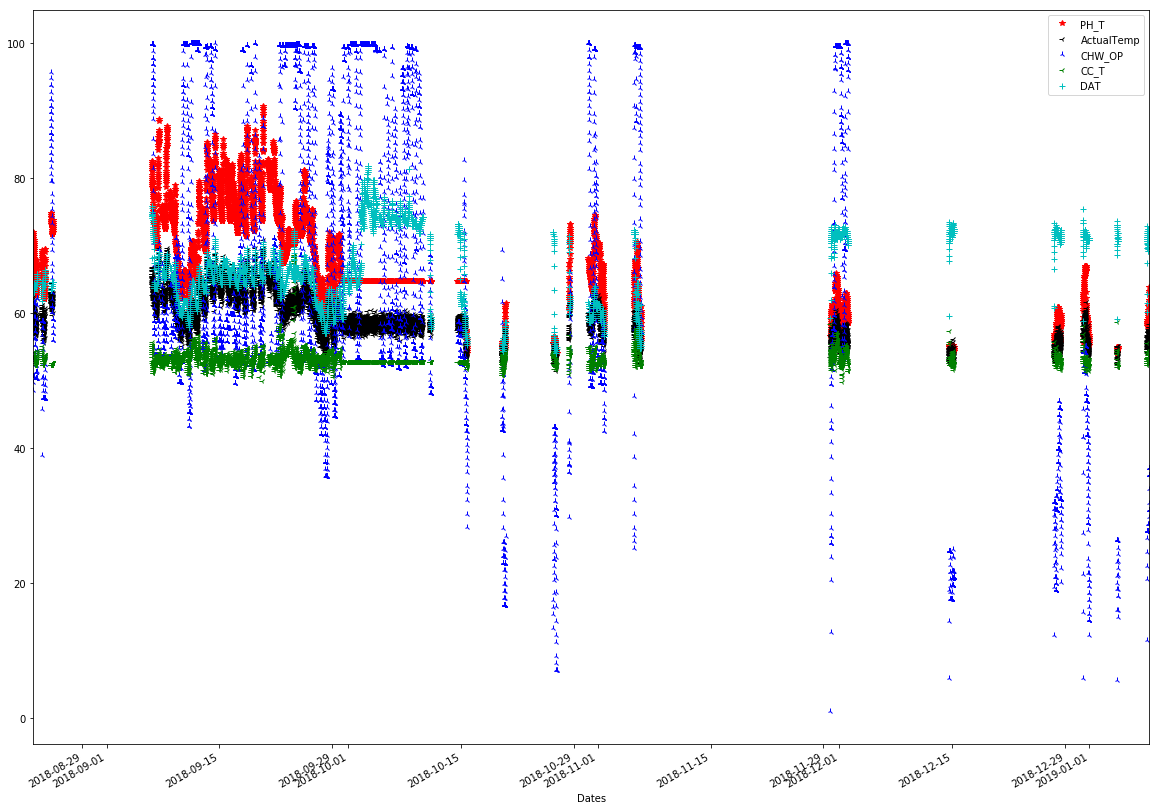

In [26]:
RL_data.plot( y=[8,'ActualTemp',3,10,1],style=['r*','k3','b2','g3','c+'],figsize=(20,15),label=['PH_T','ActualTemp','CHW_OP','CC_T','DAT'])

In [15]:
RL_data['ActualTemp'] = RL_data.apply(lambda x: CooledAirTemp(x[8],x[7]) , axis=1)

In [121]:
#To understand the causes of COOL_OP from ActualTemp and DAT_SPT
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

X_input = RL_data[[0,2,10,12]].to_numpy()#,10
Y_output = RL_data[[3]].to_numpy()

X_input = X_input[:-1,:]
Y_output = Y_output[1:,:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.30, shuffle=True)
learner = GBR(n_estimators=1000)
learner.fit(X_train,y_train)
learner.score(X_train,y_train)#0.8820918432991046
#learner.feature_importances_   #array([0.48856708, 0.11842395, 0.30659431, 0.08641466])
#learner.score(X_test,y_test) #0.8168580186000194
#'''I think the COOL_OP depends on the OAT>CC_T(ie the cct stpt)>AirFlow>OAH'''
#but I think we cannot include cc_t

/isis/tljh/user/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8847442930659113

In [126]:
learner.score(X_test,y_test)

0.8043642238284201

In [120]:
learner.feature_importances_

array([0.48856708, 0.11842395, 0.30659431, 0.08641466])

In [124]:
from joblib import dump, load
dump(learner, 'COOL_OP.joblib') 

['COOL_OP.joblib']

In [125]:
learner = load('COOL_OP.joblib') 

In [ ]:
'''My conclusion is that the cooling coil is always able to bring the temperature down to 53F whenever it is on based on histogram information
Now lets see how to determine the output temperature of the reheat section and how to know what the 
reheat valve is a function of'''

In [ ]:
#To understand the causes of DAT from DAT_STP ,ReheatOP, CC_T/Actual Temp
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

X_input = RL_data[[4,10,'ActualTemp']].to_numpy()#,10
Y_output = RL_data[[1]].to_numpy()

X_input = X_input[:-1,:]
Y_output = Y_output[1:,:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.30, shuffle=True)
learner = GBR(n_estimators=300)
learner.fit(X_train,y_train)
learner.score(X_train,y_train)#0.85808
#learner.feature_importances_   #array([0.74876863, 0.1394508 , 0.11178057])
#learner.score(X_test,y_test) #0.8182

In [94]:
#To understand the importance of RHT_OP
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

X_input = RL_data[[1,10,'ActualTemp',11]].to_numpy()
Y_output = RL_data[[4]].to_numpy()

X_input = X_input[:-1,:]
Y_output = Y_output[1:,:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.30, shuffle=True)
learner = GBR(n_estimators=500)
learner.fit(X_train,y_train)
learner.score(X_train,y_train)  #0.9882567561958427
#learner.feature_importances_   #array([0.86922268, 0.0280883 , 0.04215088, 0.06053814])
#learner.score(X_test,y_test)  #0.9684516004872604
#'''Hence we see that reheat output depends primarily on the DAT(t-1) and the DAT_STP(t-1) '''

/isis/tljh/user/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9897336246902735

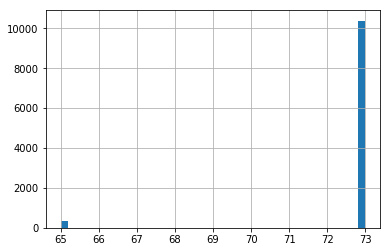

In [130]:
RL_data[11].hist(bins=40)

In [131]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaledData = scaler.fit_transform(RL_data)

/isis/tljh/user/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/isis/tljh/user/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [134]:
scaledData = DataFrame(scaledData)

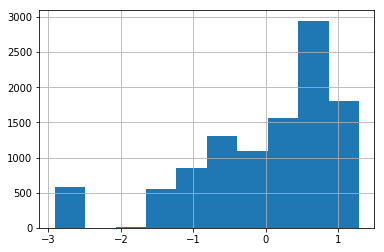

In [153]:
scaledData[13].hist()

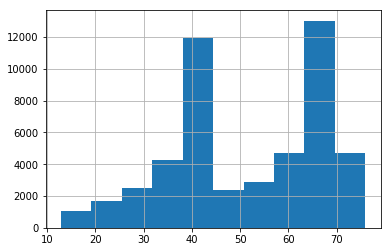

In [3]:
totalData[13].hist()

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaledData = DataFrame(scaler.fit_transform(totalData))

/isis/home/nauga/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/isis/home/nauga/.local/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


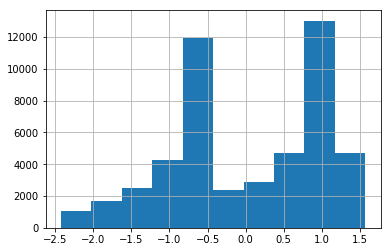

In [9]:
scaledData[13].hist()

In [10]:
scaledData.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.801338,0.938125,-2.108466,-0.689354,-0.521818,-0.636349,1.864271,0.0,0.845023,-0.665619,1.080715,-1.945905,-1.210913,0.998938,0.230633,-0.652987,-0.628667
1,1.801338,0.938125,-2.108466,-0.689354,-0.521818,-0.636349,1.864271,0.0,0.845023,-0.665619,1.080715,-1.945905,-1.210913,0.998938,0.230633,-0.652987,-0.628667
2,1.745343,0.938125,-2.108466,-0.689354,-0.521818,-0.636349,1.864271,0.0,0.845023,-0.665619,1.080715,-1.945905,-1.210913,0.998938,0.230633,-0.652987,-0.628667
3,1.745343,0.938125,-2.108466,-0.689354,-0.521818,-0.636349,1.864271,0.0,0.845023,-0.665619,1.080715,-1.945905,-1.210913,0.998938,0.230633,-0.652987,-0.628667
4,1.763704,0.938125,-2.108466,-0.689354,-0.521818,-0.636349,1.864271,0.0,0.883677,-0.665619,1.044992,-1.945905,-1.449389,0.872174,0.164330,-0.652987,-0.628667


In [11]:
totalData.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,PH_T_energy,Cooling_energy
Dates,,,,,,,,,,,,,,,,,
2018-07-13 12:50:00,94.759,76.93846,-3.779796,0.0,0.0,0.0,73.0,53.0,75.954407,0.0,71.692268,65.0,48.0,66.9,30.14,0.0,0.0
2018-07-13 12:55:00,94.759,76.93846,-3.779796,0.0,0.0,0.0,73.0,53.0,75.954407,0.0,71.692268,65.0,48.0,66.9,30.14,0.0,0.0
2018-07-13 13:00:00,93.742,76.93846,-3.779796,0.0,0.0,0.0,73.0,53.0,75.954407,0.0,71.692268,65.0,48.0,66.9,30.14,0.0,0.0
2018-07-13 13:05:00,93.742,76.93846,-3.779796,0.0,0.0,0.0,73.0,53.0,75.954407,0.0,71.692268,65.0,48.0,66.9,30.14,0.0,0.0
2018-07-13 13:10:00,94.0755,76.93846,-3.779796,0.0,0.0,0.0,73.0,53.0,76.256523,0.0,71.388237,65.0,44.0,64.9,30.13,0.0,0.0
